# Mixture of Gaussians with Edward2

In [43]:
!pip install edward
!pip install edward2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for edward: filename=edward-1.3.5-py3-none-any.whl size=90385 sha256=2d02dd2c57df7909127b2ab9276a8880c07244034270ab5314759428d7f90ef7
  Stored in directory: /root/.cache/pip/wheels/c0/d0/6f/298c809cc8db6573b8642d1473c668868a67b9ad297c2e8b65
Successfully built edward
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import edward2 as ed
import pandas as pd
import numpy as np
tfd = tfp.distributions

Since Tensorflow 2, Edward uses Tensorflow's Mixture class instead of its own class. So we will declare the mixture of gaussians in the same way as we did when working with Tensorflow Probability. (Reference: http://edwardlib.org/api/ed/models/Mixture)

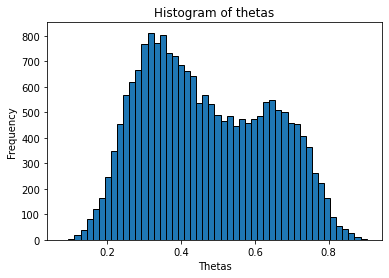

In [31]:
sample_size = 20000 # Number of experiments we will perform
n_throws = 10 # Number of times each coin is flipped
m_heads = 3 # Number of heads obtained

# Generate the thetas given from the Mixture of the three Beta distributions
gmm = tfd.Mixture(
    cat=tfd.Categorical(probs=[0.5, 0.2, 0.3]),
    components=[
        tfd.Beta(10,20),
        tfd.Beta(15,15),
        tfd.Beta(20,10),
    ]
)
thetas = gmm.sample(sample_size)

# Simulated prior
plt.title('Histogram of thetas')
plt.xlabel('Thetas')
plt.ylabel('Frequency')
plt.hist(thetas, bins=50, ec='black')
plt.show()


Now we can simulate the coin tossing with Edward2. Each coin will be thrown `n_throws` times.

In [32]:
# Number of heads in m trials
heads = ed.Binomial(total_count=n_throws, probs=thetas)

Next, show the frequency of heads and the prior predictive pmf for the simulation. We can follow the same steps as in the previous implementations.

In [33]:
# Group by the number of heads
unique, counts = np.unique(heads.numpy(), return_counts=True)
heads_table = pd.DataFrame({
    'counts': counts, 
    'frequency': counts/sample_size
    }, index=pd.Index(unique, name='heads'))

In [34]:
print("Absolute Frequencies")
heads_table[['counts']].T


Absolute Frequencies


heads,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
counts,302,1195,2267,2873,3124,2997,2630,2151,1460,763,238


In [35]:
print("Relative Frequencies")
heads_table[['frequency']].T

Relative Frequencies


heads,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
frequency,0.0151,0.05975,0.11335,0.14365,0.1562,0.14985,0.1315,0.10755,0.073,0.03815,0.0119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


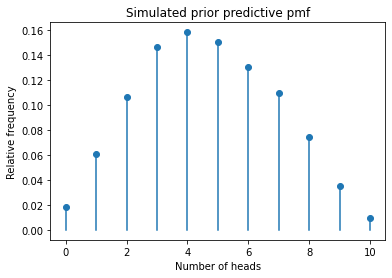

In [ ]:
plt.xlabel('Number of heads')
plt.ylabel('Relative frequency')
plt.title('Simulated prior predictive pmf')
plt.stem(heads_table.index, heads_table['frequency'], basefmt=" ")
plt.show()

To finish, the histogram of thetas that produce exactly 3 heads can be replicated.

Number of times we get 3 heads: 2873
Proportion of samples with m=3 heads:  0.14365


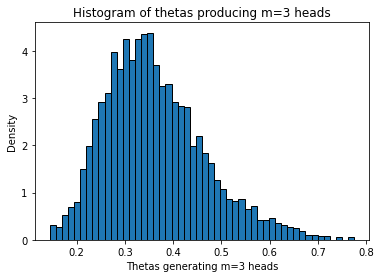

In [36]:
# Cases in which we get m=3 heads
num_m_heads_heads = heads_table.loc[m_heads, 'counts']
print('Number of times we get {} heads: {}'.format(m_heads, num_m_heads_heads))

# Proportion of cases in which we get m=3 heads
print("Proportion of samples with m=3 heads: ", heads_table.loc[m_heads, 'frequency'])

# Thetas that have generated m=3 heads
thetas_m_heads = thetas[heads == m_heads]

# The histogram shows the theta values generating m=3 heads
plt.title('Histogram of thetas producing m=3 heads')
plt.xlabel('Thetas generating m=3 heads')
plt.ylabel('Density')
hist = plt.hist(thetas_m_heads, bins=50, ec='black', density=True)
plt.show()

## Map estimator of $\theta$

Given the simulations performed before, the MAP can be estimated as the theta value with maximal density. Edward used to include MAP estimation as inference (http://edwardlib.org/api/ed/MAP), but it is still not available in Edward2. Sadly, we will have to continue imitating what has been done with Tensorflow Probability.

In [50]:
# Do not work because of not found
# from edward2 import MAP
# from edward2.VariationalInference import MAP
# from edward2.inferences import MAP

# Do not work because of "No module named 'tensorflow.contrib'" (compatibility issues)
# from edward import MAP
# from edward.VariationalInference import MAP
# from edward.inferences import MAP

MAP:  0.34611142


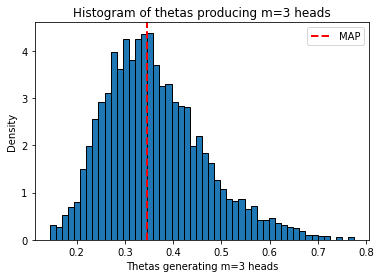

In [46]:
# Finding the maximum a posteriori (MAP)
# Finding MAP
theta_MAP = hist[1][np.argmax(hist[0])]
print("MAP: ", theta_MAP)
# Plot over histogram
plt.title('Histogram of thetas producing m=3 heads')
plt.xlabel('Thetas generating m=3 heads')
plt.ylabel('Density')
plt.hist(thetas_m_heads, bins=50, ec='black', density=True)
plt.axvline(theta_MAP, color='red', linestyle='dashed', linewidth=2, label='MAP')
plt.legend()
plt.show()

The following computations are expected to be computed in the same way as in our Tensorflow Probability implementation. (Reference: https://github.com/google/edward2/blob/main/Upgrading_From_Edward_To_Edward2.md)

## Posterior Expectation

In [51]:
# Simulated Expectation 
print("Simulation based posterior expectation: ", tf.reduce_mean(thetas_m_heads).numpy())

Simulation based posterior expectation:  0.36187643


## Posterior Variance

In [52]:
# Simulated Variance
print("Simulation based posterior variance: ", tf.math.reduce_variance(thetas_m_heads).numpy())

Simulation based posterior variance:  0.010641968
